## Importations

This notebook is ran in a virtual environment in Ubuntu 20.04.2 LTS

Spark version: spark-2.4.7-bin-hadoop2.7

Java 8 !!!!!!!!!!!!!

In [1]:
import os

Findspark : to use spark within a jupyter notebook

Findspark needs the environment variable SPARK_HOME to work (indicate the spark directory).

In [2]:
# ensure SPARK_HOME is correctly set (in .bashrc)
os.environ['SPARK_HOME']

'/home/maryse/spark-2.4.7-bin-hadoop2.7'

Import findspark and initialize findspark (allow to use Spark with the notebook)

In [3]:
import findspark
findspark.init()

Sets the environnement variable 'PYSPARK_SUBMIT_ARGS' in order to fetch the databricks sparkdl package, as soon as the pyspark-submit command will be run

In [4]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.2,databricks:spark-deep-learning:1.5.0-spark2.4-s_2.11 pyspark-shell'

Import basic modules

In [5]:
import pandas as pd 
import numpy as np
import cv2

Import pyspark

In [6]:
import pyspark

In [7]:
# # Explore functions of a module
# from inspect import getmembers, isfunction
# print(pd.DataFrame(getmembers(pyspark.sql)))

## Configurations ...

In [8]:
# # extraction of AWS access keys from key file
# with open('XXXXXXX,'r') as f:
#         msg = f.read()
          
# ID= str(msg).split('\n')[0]
# KEY= msg.split('\n')[1]

# # set "temporary" environment variables
# os.environ["AWS_ACCESS_KEY_ID"]=ID
# os.environ["AWS_SECRET_ACCESS_KEY"]=KEY

Create and set parameters of the Hadoop configuration

In [9]:
# hadoopConf = sc._jsc.hadoopConfiguration()

# hadoopConf.set('fs.s3a.awsAccessKeyId',
#                ID)
# hadoopConf.set('fs.s3a.awsSecretAccessKey',
#                KEY)
# hadoopConf.set('fs.s3a.endpoint',
#                's3-us-east-2.amazonaws.com')
# hadoopConf.set('com.amazonaws.services.s3a.enableV4',
#                'true')
# hadoopConf.set('fs.s3a.impl',
#                'org.apache.hadoop.fs.s3a.S3AFileSystem')

## Instantiation of SparkContext and import sparkdl

Let's instantiate our SparkContext

In [10]:
# # SparkContext become useless if SparkSession (spark.sql) is created
# from pyspark import SparkContext, SparkConf

In [11]:
# # En cas de pbe lié aux serveurs S3 choisis
# conf = (SparkConf().set('spark.executor.extraJavaOptions',
#                         '-Dcom.amazonaws.services.s3.enableV4=true')\
#                    .set('spark.driver.extraJavaOptions',
#                         '-Dcom.amazonaws.services.s3.enableV4=true'))

In [12]:
# # Default SparkContext
# sc = SparkContext()

# # # Custom SparkContext
# # sc=SparkContext(conf=conf)
# # sc.setSystemProperty('com.amazonaws.services.s3.enableV4',
# #                      'true')

In [13]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('FeatExtr').getOrCreate()

Then only we import sparkdl

In [14]:
import warnings
# show only one warning if multiple warnings in the same cell
warnings.filterwarnings("ignore") # "once"

import sparkdl

Using TensorFlow backend.


## Create a Spark DataFrame containing all the pictures

### Read images and vectorize

In [15]:
from pyspark.ml.image import ImageSchema

In [16]:
# Option1: Get local data

path = "./DATA/fruits-360/SAMPLE" # /Corn"
    
# # Option2: Get data from s3

# bucket='ocfruitpictures'
# folder = 'SAMPLE/Corn'
# data_loc = 's3://{}/{}'.format(bucket, folder)

In [17]:
# os.path.join(path, '170_100.jpg')

Reads recursively all images in the specified directory, put in a Spark DataFrame

In [18]:
images_df = ImageSchema.readImages(path, recursive=True)

Show the content of the Spark DataFrame

In [19]:
images_df.show()

+--------------------+
|               image|
+--------------------+
|[file:/home/marys...|
|[file:/home/marys...|
|[file:/home/marys...|
|[file:/home/marys...|
|[file:/home/marys...|
|[file:/home/marys...|
|[file:/home/marys...|
|[file:/home/marys...|
|[file:/home/marys...|
|[file:/home/marys...|
|[file:/home/marys...|
|[file:/home/marys...|
|[file:/home/marys...|
|[file:/home/marys...|
|[file:/home/marys...|
|[file:/home/marys...|
|[file:/home/marys...|
|[file:/home/marys...|
|[file:/home/marys...|
|[file:/home/marys...|
+--------------------+
only showing top 20 rows



In [20]:
images_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)



Now we've got a Spark DataFrame containing all the images, each as one row.

### Display sample picture

Extract first picture

In [23]:
# extract first row of the DataFrame
row0 = images_df.first()

In [26]:
row0.asDict()['image']['mode']

16

In [27]:
# transform the row in a dict, and turn the data in a 1D np.array
mat0 = np.array(row0.asDict()['image']['data'])
# reshape the 1D vector into a 3 channel, 2D np.array of pixels
mat0 = mat0.reshape(100, 100, 3)[:, :, ::-1] # reverse BGR to RGB
mat0.shape

(100, 100, 3)

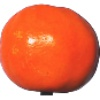

In [28]:
from PIL import Image
# Display sample image
Image.fromarray(mat0, 'RGB')

## Features extraction (Transfer Learning) using Sparkdl

In [30]:
from sparkdl import DeepImageFeaturizer

In [31]:
# Instantiation of the featurizer
feat = DeepImageFeaturizer(inputCol="image",
                           outputCol="image_features",
                           modelName="ResNet50")

Instantiation of a sparkdl pipeline to process the image data

In [32]:
from pyspark.ml import Pipeline

pipe = Pipeline(stages=[feat])
extractor = pipe.fit(images_df)

In [33]:
ext_features_df = extractor.transform(images_df)
ext_features_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)
 |-- image_features: vector (nullable = true)



In [34]:
ext_features_df.show()

+--------------------+--------------------+
|               image|      image_features|
+--------------------+--------------------+
|[file:/home/marys...|[0.24925154447555...|
|[file:/home/marys...|[0.45899030566215...|
|[file:/home/marys...|[2.24640989303588...|
|[file:/home/marys...|[1.94920766353607...|
|[file:/home/marys...|[0.53471016883850...|
|[file:/home/marys...|[0.02559056505560...|
|[file:/home/marys...|[0.10091863572597...|
|[file:/home/marys...|[0.13858571648597...|
|[file:/home/marys...|[0.08605482429265...|
|[file:/home/marys...|[0.00671436730772...|
|[file:/home/marys...|[0.06267129629850...|
|[file:/home/marys...|[0.01391865313053...|
|[file:/home/marys...|[0.03199945762753...|
|[file:/home/marys...|[0.0,1.0963382720...|
|[file:/home/marys...|[0.04331192746758...|
|[file:/home/marys...|[0.05217304080724...|
|[file:/home/marys...|[0.0,0.0012494423...|
|[file:/home/marys...|[0.55651140213012...|
|[file:/home/marys...|[0.10565294325351...|
|[file:/home/marys...|[0.1040508

In [38]:
# # compare the size of the Spark DataFrame (prior action)
# # and that of a Pandas DataFrame

# import sys
# print(sys.getsizeof(ext_features_df),
#       sys.getsizeof(ext_features_df.toPandas()))

64 3360


## PCA on the extracted features

In [39]:
from pyspark.ml.feature import PCA

# take only the extracted features
pca_features_df = ext_features_df.select('image_features')
# pca_features_df.show()

In [41]:
# instantiate Spark PCA model
pca = PCA(k=8,
          inputCol="image_features",
          outputCol="pca_features")

In [43]:
# fit the model
model = pca.fit(pca_features_df)

In [46]:
# cumulative explained variance
cumValues = model.explainedVariance.cumsum()

Text(0, 0.5, 'Cumulative explained variance')

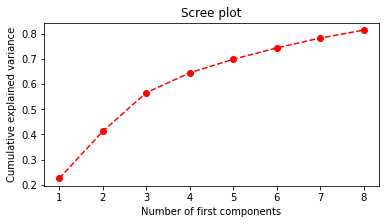

In [51]:
# show the scree plot

import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor']='w'
plt.figure(figsize=(6,3))
plt.plot(range(1,9), cumValues, color='r',
         marker = 'o', linestyle='--')
plt.title('Scree plot')
plt.xlabel('Number of first components')
plt.ylabel('Cumulative explained variance')